In [1]:
import pybomwater.bom_water as bm
from sidecar import Sidecar
from ipyleaflet import Map, GeoJSON, Polygon
from IPython.display import display, clear_output, HTML, JSON
import json
import requests
import geopandas as gpd

## Get Capability

In [2]:
_bm = bm.BomWater()
response = _bm.request(_bm.actions.GetCapabilities)
# response
JSON(_bm.xml_to_json( response.text))

<IPython.core.display.JSON object>

## Get Observation

Return data type is a Pandas DataFrame

http://bom.gov.au/waterdata/services/stations/GW403571.1.1
http://bom.gov.au/waterdata/services/stations/GW500596.3.3
http://bom.gov.au/waterdata/services/stations/GW500596.3.3
http://bom.gov.au/waterdata/services/stations/GW403571.1.1


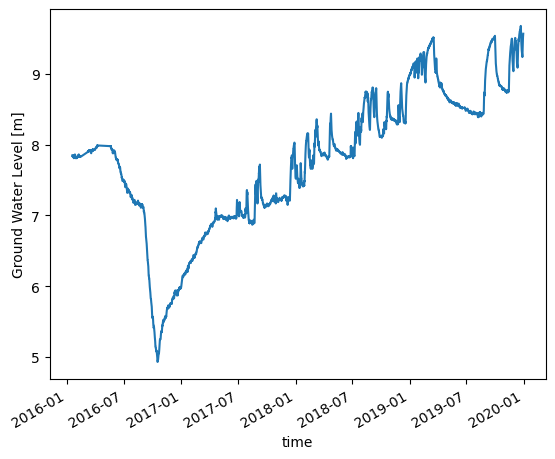

In [19]:
t_begin = "2016-01-01T00:00:00+10"
t_end = "2019-12-31T00:00:00+10"

features = []
features.append(_bm.features.West_of_Dellapool)
features.append(_bm.features.LK_VIC)

prop = _bm.properties.Ground_Water_Level
proced = _bm.procedures.Pat9_C_B_1

bbox = [None, None]

results = _bm.get_observations(features, prop, proced, t_begin, t_end, bbox)
results[0][_bm.features.West_of_Dellapool]['Ground Water Level [m]'].plot.line()

## Get Data availability

In [20]:
response = _bm.request(_bm.actions.GetDataAvailability, _bm.features.Cowra_Back_Ck_Nth_P2, _bm.properties.Ground_Water_Level)
JSON(_bm.xml_to_json( response.text))

<IPython.core.display.JSON object>

## Get Feature of interest
Simple demo of requesting features within a bounding box and mapping their locations

In [21]:
low_left_lat = -37.505032
low_left_long = 138.00
upper_right_lat = -24.00
upper_right_long = 154.00

lower_left_coords = f'{low_left_lat} {low_left_long}'
upper_right_coords = f'{upper_right_lat} {upper_right_long}'

_bm = bm.BomWater()

# request( action, feature=None, prop=None, proced=None, begin=None, end=None, lower_corner=None, upper_corner=None)

response = _bm.request(_bm.actions.GetFeatureOfInterest, None, _bm.properties.Water_Course_Discharge, _bm.procedures.Pat4_C_B_1_DailyMean, None, None, lower_left_coords, upper_right_coords  )
response_json = _bm.xml_to_json(response.text)
'''bomwater creates a FeatureCollection which can be used for mapping'''
feature_list = _bm.create_feature_list(response_json, None )

bbox_poly = Polygon(
        locations=[(low_left_lat, low_left_long),(low_left_lat, upper_right_long),(upper_right_lat, upper_right_long),(upper_right_lat, low_left_long)],
    color="green",
    fill_color="green"
        )
m = Map(center=(-32, 146), zoom=5)

geojsonMarkerOptions = {
    'radius': 8,
    'fillColor': "#ff7800",
    'color': "#000",
    'weight': 1,
    'opacity': 1,
    'fillOpacity': 0.8
};

geo_json_stations = GeoJSON(
    data=feature_list,
    point_style={'radius': 5, 'color': 'blue', 'fillOpacity': 0.8, 'fillColor': 'green', 'weight': 2})

def random_color(feature):
    return {
        'color': 'black',
        'fillColor': 'green',#random.choice(['red', 'yellow', 'green', 'orange']),
    }

shp_mdb = './bomwater_data/Spatial/mdb_buffer_1km.shp'
mdb = json.loads(gpd.read_file(shp_mdb).to_json())['features'][0]['geometry']

geo_json_mdb = GeoJSON(
    data=mdb,
    style={
        'opacity': 1, 'dashArray': '9', 'fillOpacity': 0.1, 'weight': 1
    },
    hover_style={
        'color': 'green', 'dashArray': '0', 'fillOpacity': 0.3
    },
    style_callback=random_color
)

m.add_layer(geo_json_mdb)
# m.add_layer(bbox_poly)
m.add_layer(geo_json_stations)

display(m)

'''Display the json response'''
# JSON(response_json)

Map(center=[-32, 146], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

'Display the json response'